In [1]:
#Test to figure out how much data is needed for training
import mne
import scipy.io as sp
import numpy as np
import random
import pandas as pd
import multiprocessing as mp
import concurrent.futures
from mne.decoding import CSP
import pymrmr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import logging



In [2]:
num_channels = 64
epoch_length = 1123
sampling_freq = 250
number_of_runs = 10
number_of_splits = 10
number_of_components = 10
number_of_selected_features = 10
number_of_processes = 15
number_of_bands = 9
# rf = pd.DataFrame()
column_names = ['participant', 'class1', 'class2','running_time','test_acc','train_acc','test_size','train_size','train_block','test_block']
# rf = rf.reindex(columns=column_names)


In [5]:
# #Frame Maker
# df = pd.read_csv("frame.csv")
# for i in range(2,16):
#     if i!=9:
#         df.to_csv('P'+str(i)+'.csv',index=False)
    

In [3]:
def calc_csp(x_train, y_train, x_test):
    
        csp = CSP(number_of_components)
        csp_fit = csp.fit(x_train, y_train)
        train_feat = csp_fit.transform(x_train)
        test_feat = csp_fit.transform(x_test)
        return train_feat, test_feat

In [4]:
def class_extraction(number_of_epochs, class_1, class_2, data, labels):
    size = sum(labels[:,0] == class_1) + sum(labels[:,0] == class_2)
    Final_labels = np.zeros((size,1)).astype(int)
    dataset = np.zeros((size,num_channels, epoch_length))
    index = 0
    for i in range(number_of_epochs):
        if labels[i,0] == class_1 or labels[i,0] == class_2:
            dataset[index,:,:] = data[i,:,:]
            Final_labels[index,0] = labels[i,0]
            index = index + 1
        else:
            continue
            
    return dataset, Final_labels

In [5]:
def feature_extraction(dataset, labels, number_of_bands, test_data):

    low_cutoff = 0
    
    for b in range(number_of_bands):
        logging.getLogger('mne').setLevel(logging.WARNING)
        low_cutoff += 4
        data = dataset.copy()
        data_test = test_data.copy()
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, n_jobs = 4)
        filtered_data_test = mne.filter.filter_data(test_data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, n_jobs = 4)
        [train_feats, test_feats] = calc_csp(filtered_data, labels[:,0], filtered_data_test)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
    
    return train_features, test_features

In [6]:
def feature_selection(train_features, labels, number_of_selected_features):
    X = pd.DataFrame(train_features)
    y = pd.DataFrame(labels)
    K = number_of_selected_features
    
    df = pd.concat([y,X], axis = 1)
    df.columns = df.columns.astype(str)
        
    selected_features = list(map(int, pymrmr.mRMR(df, 'MID', K)))
    return selected_features

In [7]:
def data_reader(path):
    data = mne.read_epochs_eeglab(path)
    data = data.to_data_frame()
    return data

In [8]:
# data.tail()
def left_epoch_finder(data):
    cutdata = data[data['condition']=='Left']
    left_epochs_list = cutdata['epoch'].unique()
    return left_epochs_list

In [9]:
def find_starting_points(numbers):
    starting_points = []
    current_group = []

    for i, num in enumerate(numbers):
        if i == 0 or num != numbers[i-1] + 1:
            # Start of a new group
            current_group = [num]
            starting_points.append(num)
        else:
            current_group.append(num)

    return starting_points


In [10]:
def preprocessor(X_train_df,X_test_df,data):
    
    X1 = X_train_df[X_train_df.columns[3:]].to_numpy()
    X1 = np.transpose(X1)
    print(X1.shape)
    
    X2 = X_test_df[X_test_df.columns[3:]].to_numpy()
    X2 = np.transpose(X2)  
    # number_of_epochs_tr = int(len(X_train_df)/epoch_length)
    # number_of_epochs_te = int(len(X_test_df)/epoch_length)
    
    epoch_range_X_tr = X_train_df['epoch'].unique()
    epoch_range_data = data['epoch'].unique()
    epoch_range_X_te = X_test_df['epoch'].unique()
    a = epoch_range_X_tr
    b = epoch_range_data
    c = epoch_range_X_te
    # print(a,b,"ab")
    number_of_epochs_tr= a[-1]-a[0]+1
    number_of_epochs_te = c[-1]-c[0]+1
    thr_up = a[-1]
    thr_dw = a[0]
    period = a[-1]-a[0]+1
    number_of_epochs_all = b[-1]-b[0]+1
    thr_dw_te = c[0]
    # number_of_epochs_te = number_of_epochs_all-number_of_epochs_tr
    print(number_of_epochs_te,"number_of_epochs_te")
    # random.seed(42)
    randomlist_all = random.sample(range(b[0],b[-1]+1),number_of_epochs_all)
    randomlist_tr = random.sample(range(a[0],a[-1]+1),number_of_epochs_tr)
    randomlist_te = random.sample(range(c[0],c[-1]+1),number_of_epochs_te)
    print(c[0],c[-1],"c0c-1")
    # randomlist_te = [i for i in randomlist_all if i not in randomlist_tr]
    # print(randomlist_te,"randomlist_te")
    # print(randomlist_te)
    
    # randomlist_tr = random.sample(range(number_of_epochs_tr), number_of_epochs_tr)
    # randomlist_te = random.sample(range(number_of_epochs_tr,(number_of_epochs_tr+number_of_epochs_te)),number_of_epochs_te)

    data_tr = np.zeros((number_of_epochs_tr,num_channels, epoch_length))
    labels_tr = np.zeros((number_of_epochs_tr,1)).astype(int)
    
    data_te = np.zeros((number_of_epochs_te,num_channels, epoch_length))
    labels_te = np.zeros((number_of_epochs_te,1)).astype(int)

    for i in range(number_of_epochs_tr):
        # print(randomlist_tr[i])
        c = 1 if randomlist_tr[i]>=period else 0
        d = randomlist_tr[i]-(c*thr_dw)
        data_tr[i,:,:] = X1[:, d*epoch_length:(d + 1)*epoch_length]
        if (X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Left'):
            labels_tr[i,0] = 0
        elif(X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Right'):
            labels_tr[i,0] = 1
        elif(X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Feet'):
            labels_tr[i,0] = 2
        elif(X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Tongue'):
            labels_tr[i,0] = 3
        elif(X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Mis'):
            labels_tr[i,0] = 4
        elif(X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Si'):
            labels_tr[i,0] = 5
        elif(X_train_df['condition'][randomlist_tr[i]*epoch_length] == 'Rest'):
            labels_tr[i,0] = 6
        else:
            raise Exception("Labeling Error!!!")          
      
    for i in range(number_of_epochs_te):
        # print(randomlist_te[i],"test")
        # print(thr_up,"thr_up")
        # print(period,"period")
        # print(d,"d")
        # c = 1 if randomlist_te[i]>thr_up else 0
        # d = randomlist_te[i] - (c*period)
        d = randomlist_te[i]-thr_dw_te
        data_te[i,:,:] = X2[:, d*epoch_length:(d + 1)*epoch_length]
        if (X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Left'):
            labels_te[i,0] = 0
        elif(X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Right'):
            labels_te[i,0] = 1
        elif(X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Feet'):
            labels_te[i,0] = 2
        elif(X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Tongue'):
            labels_te[i,0] = 3
        elif(X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Mis'):
            labels_te[i,0] = 4
        elif(X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Si'):
            labels_te[i,0] = 5
        elif(X_test_df['condition'][randomlist_te[i]*epoch_length] == 'Rest'):
            labels_te[i,0] = 6
        else:
            raise Exception("Labeling Error!!!")
     
    return data_tr,data_te,labels_tr,labels_te,number_of_epochs_tr,number_of_epochs_te
    

In [12]:
class_2 = 6
# train_acc_list = []
# test_acc_list = []
class_1_list=[1,3,4]
p_num_list = [2]
for P_num in p_num_list:

        data = data_reader('/project/6067835/mahdi146/Cedar/Data/P'+str(P_num)+'.set')
        left_epochs_list = left_epoch_finder(data)
        starting_left_epochs = find_starting_points(left_epochs_list)
        starting_left_samples = [epoch_length* item for item in starting_left_epochs]
        
        print(starting_left_epochs,"starting_left_epochs")
        print(starting_left_samples,"starting_left_samples")
        tr_blk_list=[1,12,123,1234]
        for trblk in range(1,5):
            upper_margin_tr=starting_left_samples[trblk]
            data1 = data.copy()
            X_train = data1[0:upper_margin_tr]
            
            
            for blk in range(trblk,7):

                if blk==6:
                    data1 = data.copy()
                    lower_margin_te = starting_left_samples[blk]
                    X_test = data1[lower_margin_te:]
                    
                else:
                    data1 = data.copy()
                    lower_margin_te = starting_left_samples[blk]
                    upper_margin_te = starting_left_samples[blk+1]
                    X_test = data1[lower_margin_te:upper_margin_te]   
                    

                tr_blk = tr_blk_list[trblk-1]
                te_blk = blk+1
                print(f"\n\n\n\n\nwe are in blc num {te_blk} :\n\n\n\n\n")
                
                for class_1 in class_1_list:
                    import time
                    start_time = time.time() 
                    train_acc_list = []
                    test_acc_list = []
                    for r in range(5):
                        data1 = data.copy()   
                        X_tr_raw,X_te_raw,y_tr_raw,y_te_raw,number_of_epochs_tr,number_of_epochs_te = preprocessor(X_train,X_test,data1)
                        [X_tr, y_tr] = class_extraction(number_of_epochs_tr, class_1, class_2, X_tr_raw, y_tr_raw)
                        [X_te, y_te] = class_extraction(number_of_epochs_te, class_1, class_2, X_te_raw, y_te_raw) 
                        print(X_te.shape,"X_te.shape")
                        [X_train_features, X_test_features] = feature_extraction(X_tr, y_tr, number_of_bands, X_te)                          
                        selected_features = feature_selection(X_train_features, y_tr, number_of_selected_features)  
                        print(X_train_features.shape,"X_train_features.shape")
                        print(y_tr.shape,"y_tr.shape")
                        # clf = RF(n_jobs=-1,random_state=42)
                        # clf = RF(n_jobs=-1)
                        clf = RF()
                        clf.fit(X_train_features[:, selected_features], y_tr[:,0])
                        
                        y_pr_te = clf.predict(X_test_features[:, selected_features])
                        y_pr_tr = clf.predict(X_train_features[:,selected_features])
                    
                        accuracy_te = accuracy_score(y_te, y_pr_te)
                        test_acc_list.append(accuracy_te)

                        accuracy_tr = accuracy_score(y_tr,y_pr_tr)
                        train_acc_list.append(accuracy_tr)
                        
                        class__1 = class_1
                        class__2 = class_2
                    end_time = time.time()
                
                    time = end_time-start_time
                    print(time,"time")
                    print(test_acc_list,"\n\n\n\n\n\ntest_acc_list\n\n\n\n\n")
                    
                    class_dict = {0:"Left",1:"Right",2:"Feet",3:"Tongue",4:"Mis",5:"Si",6:"Rest"}
                    participant = P_num
                    class1 = class_dict[class__1]
                    class2 = class_dict[class__2]
                    running_time = time
                    test_acc = np.average(test_acc_list)
                    train_acc = np.average(train_acc_list)
                    test_size = X_te.shape
                    train_size = X_tr.shape
                    train_block = tr_blk
                    test_block = te_blk
                
                    new_row = [participant, class1, class2,running_time,test_acc,train_acc,test_size,train_size,train_block,test_block]
                
                    new_row_df = pd.DataFrame([new_row], columns=column_names)
                    rf = pd.read_csv('P'+str(22)+'.csv')
                    cf = pd.concat([rf, new_row_df], ignore_index=True)
                    cf.to_csv('P'+str(22)+'.csv',index=False)

    
    

/tmp/ipykernel_8793/2716586413.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['FCz']
  data = mne.read_epochs_eeglab(path)


[0, 70, 140, 210, 280, 350, 420] starting_left_epochs
[0, 78610, 157220, 235830, 314440, 393050, 471660] starting_left_samples





we are in blc num 2 :





(64, 78610)
70 number_of_epochs_te
70 139 c0c-1
(20, 64, 1123) X_te.shape
(20, 90) X_train_features.shape
(20, 1) y_tr.shape
(64, 78610)
70 number_of_epochs_te
70 139 c0c-1
(20, 64, 1123) X_te.shape


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(columns=column_names)
df.to_csv('frame.csv',index=False)

In [28]:
left_epochs_list = left_epoch_finder(data)
# print(left_epochs_list)
starting_left_epochs = find_starting_points(left_epochs_list)
starting_left_samples = [epoch_length* item for item in starting_left_epochs]
print(starting_left_samples)

[0, 78610, 157220, 235830, 314440, 393050, 471660]


In [12]:
df = pd.read_csv('P2.csv')

In [13]:
df = pd.read_csv('P2.csv')
fdfr = df[(df['train_block'] == 1) & (df['class1'] == 'Right')]
fdfs = df[(df['train_block'] == 1) & (df['class1'] == 'Si')]
fdfr.head(10)

,participant,class1,class2,running_time,test_acc,train_acc,test_size,train_size,train_block,test_block
0,2,Right,Rest,6.338198,1.00,1.0,"(20, 64, 1123)","(20, 64, 1123)",1,2
2,2,Right,Rest,4.512489,0.80,1.0,"(20, 64, 1123)","(20, 64, 1123)",1,3
4,2,Right,Rest,4.500768,0.80,1.0,"(20, 64, 1123)","(20, 64, 1123)",1,4
6,2,Right,Rest,4.496808,0.90,1.0,"(20, 64, 1123)","(20, 64, 1123)",1,5
8,2,Right,Rest,4.523510,0.75,1.0,"(20, 64, 1123)","(20, 64, 1123)",1,6
10,2,Right,Rest,4.672908,0.90,1.0,"(20, 64, 1123)","(20, 64, 1123)",1,7


In [14]:
right = fdfr["test_acc"].tolist()
si = fdfs["test_acc"].tolist()
x_axis = fdfr["test_block"].tolist()
print(si,right)


[0.65, 0.9, 0.6, 0.6, 0.65, 0.7] [1.0, 0.8, 0.8, 0.9, 0.75, 0.9]


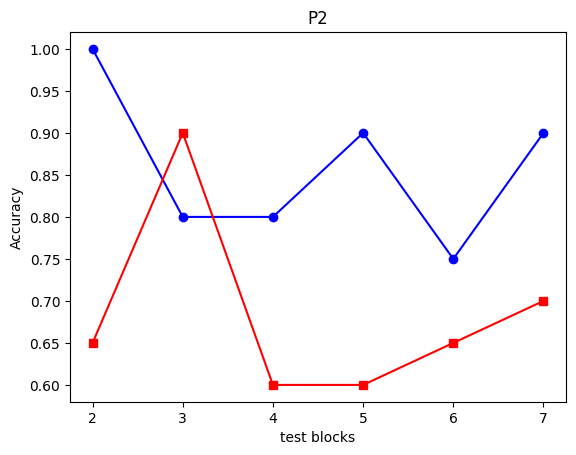

In [15]:
x =x_axis
y1 = right
y2 = si
plt.plot(x, y1, label='right', color='blue', marker='o')
plt.plot(x, y2, label='si', color='red', marker='s')

plt.xlabel('test blocks')
plt.ylabel('Accuracy')
plt.title('P2')
plt.show()

# plt.savefig('TimeSiVsRest.jpg', format='jpeg')

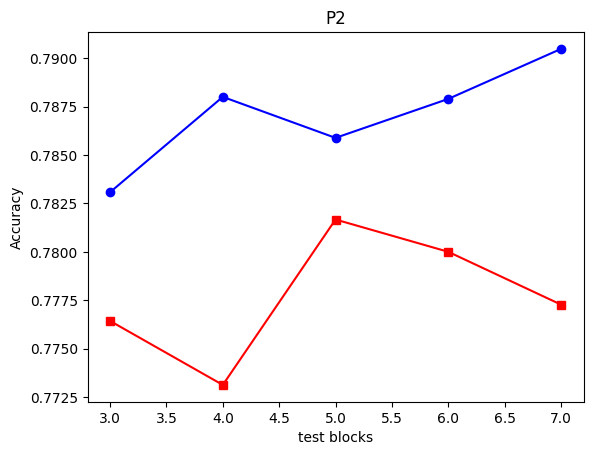

In [19]:
fdfr = df[(df['train_block'] == 12) & (df['class1'] == 'Right')]
fdfs = df[(df['train_block'] == 12) & (df['class1'] == 'Si')]
right = fdfr["test_acc"].tolist()
si = fdfs["test_acc"].tolist()
x_axis = fdfr["test_block"].tolist()
x =x_axis
y1 = right
y2 = si
plt.plot(x, y1, label='right', color='blue', marker='o')
plt.plot(x, y2, label='si', color='red', marker='s')

plt.xlabel('test blocks')
plt.ylabel('Accuracy')
plt.title('P2')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# Draw the first plot (line plot) on the first subplot
axes[0].plot(x, y1, label='Chart 1', color='blue', marker='o')
axes[0].set_xlabel('X-axis')
axes[0].set_ylabel('Y-axis')
axes[0].set_title('Line Plot')
axes[0].legend()

In [26]:
X_train1 = np.load("X_test_1.npy",allow_pickle=True)
X_train2 = np.load("X_test_2.npy",allow_pickle=True)
if np.array_equal(X_train1, X_train2):
    print("equal")
else:
    print("ridi")

equal


In [19]:
a = np.load("X_train_features_2.npy",allow_pickle=True)
b = np.load("X_test_features,_2.npy",allow_pickle=True)

c = np.load("X_train_features_1.npy",allow_pickle=True)
d = np.load("X_test_features,_1.npy",allow_pickle=True)

if np.array_equal(a, c):
    print("equal")
else:
    print("ridi")
    
if np.array_equal(b, d):
    print("equal")
else:
    print("ridi")    

equal
equal


In [17]:
X_tr_raw2 = np.load("X_tr_2.npy",allow_pickle=True)
X_te_raw2 = np.load("X_te,_2.npy",allow_pickle=True)
y_tr_raw2 = np.load("y_tr,_2.npy",allow_pickle=True)
y_te_raw2 = np.load("y_te,_2.npy",allow_pickle=True)

X_tr_raw1 = np.load("X_tr_1.npy",allow_pickle=True)
X_te_raw1 = np.load("X_te,_1.npy",allow_pickle=True)
y_tr_raw1 = np.load("y_tr,_1.npy",allow_pickle=True)
y_te_raw1 = np.load("y_te,_1.npy",allow_pickle=True)

if np.array_equal(X_tr_raw2, X_tr_raw1):
    print("equal")
else:
    print("ridi")
    
if np.array_equal(X_te_raw2, X_te_raw1):
    print("equal")
else:
    print("ridi")    
    
if np.array_equal(y_tr_raw2, y_tr_raw1):
    print("equal")
else:
    print("ridi") 
    
if np.array_equal(y_te_raw2, y_te_raw1):
    print("equal")
else:
    print("ridi")      

equal
equal
equal
equal


In [24]:
a = np.load("X_train_features[:, selected_features]_2.npy",allow_pickle=True)
b = np.load("y_tr[:,0]_2.npy",allow_pickle=True) 

c = np.load("X_train_features[:, selected_features]_1.npy",allow_pickle=True)
d = np.load("y_tr[:,0]_1.npy",allow_pickle=True) 

if np.array_equal(a, c):
    print("equal")
else:
    print("ridi")
    
if np.array_equal(b, d):
    print("equal")
else:
    print("ridi") 

equal
equal


In [26]:
a = np.load("X_test_features[:, selected_features]_2.npy",allow_pickle=True)
c = np.load("X_test_features[:, selected_features]_1.npy",allow_pickle=True) 

if np.array_equal(a, c):
    print("equal")
else:
    print("ridi")

equal


In [44]:
random.seed(42)

# Your code
randomlist_te = random.sample(range(70, 140), 70)
print(randomlist_te)

[84, 73, 105, 101, 98, 87, 83, 113, 117, 127, 104, 75, 107, 97, 72, 71, 128, 133, 139, 102, 108, 124, 137, 82, 115, 111, 129, 96, 121, 135, 130, 134, 70, 80, 126, 91, 119, 79, 122, 100, 94, 106, 138, 125, 116, 131, 81, 93, 89, 78, 118, 114, 103, 99, 95, 132, 90, 74, 110, 120, 123, 86, 88, 109, 92, 77, 112, 76, 136, 85]
